In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import matplotlib.colors as colors
import matplotlib
import os
import matplotlib.patches as mpatches
import pickle
import sys
import scipy
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#AdditioNa_l libaries
from scipy.optimize import curve_fit
from astropy.table import Table,join
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
from scipy.io import readsav
from mpl_toolkits import mplot3d
from scipy import stats
from scipy.ndimage import convolve
from pathlib import Path
from matplotlib.gridspec import GridSpec
from scipy.stats import kde
from scipy.stats import gaussian_kde
from scipy.stats import linregress
from numpy import percentile
from astropy.io import fits
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde as kde
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator
from scipy.optimize import minimize
from scipy.stats import norm


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
try:
    spec = Table.read(r'/Users/evansowusu/PhD_Files/Galah_Data/GALAH_DR3_main_allstar_v2.fits')
    age = Table.read(r'/Users/evansowusu/PhD_Files/GALAH_Data/GALAH_DR3_VAC_ages_v2.fits')
    spec_age_join = join(spec, age, keys='sobject_id')
    dynamics = Table.read(r'/Users/evansowusu/PhD_Files/GALAH_Data/GALAH_DR3_VAC_dynamics_v2.fits')
    galah = join(spec_age_join, dynamics, keys='sobject_id')
except:
    spec = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
    age = Table.read('data/GALAH_DR3_VAC_ages_v2.fits')
    spec_age_join = join(spec, age, keys='sobject_id')
    dynamics = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
    galah = join(spec_age_join, dynamics, keys='sobject_id',metadata_conflicts='silent')

In [4]:
latexpath ='/Users/evansowusu/Research/disc_paper_V_1.0/6361e47283deef812e1ca3db/'

# Basic Selection Cuts# Basic Selection Cuts

In [5]:
solar_type = (
    (galah['snr_c2_iraf'] > 50) & 
    (galah['flag_sp'] == 0) &
    (galah['flag_fe_h'] == 0) &
    (galah['teff'] > 5600) & (galah['teff'] < 5950) &
    (galah['logg'] > 4.15) &
    (galah['fe_h'] > -0.3) &
    (galah['fe_h'] < 0.3) &
    (galah['flag_Na_fe'] == 0) &
    (
        (galah['e_age_bstep'] / galah['age_bstep'] < 0.2) | 
        (galah['e_age_bstep'] < 2)
    )
)
high_na = galah['Na_fe'] > (0.55 - 0.5/5.5 * galah['age_bstep'])
old_sequence = (
    solar_type & 
    high_na
)

low_na = galah['Na_fe'] <= (0.55 - 0.5/5.5 * galah['age_bstep'])
young_sequence = (
    solar_type & 
    low_na
)


# selection_finite_ages = (
#     np.isfinite(galah['age_bstep'])
# )

# selection_na = (
#     (galah['flag_sp'] == 0) &
#     (galah['flag_fe_h'] == 0) & 
#     (galah['flag_Na_fe'] == 0)
# )

### Hauden's Cut

In [6]:
above_hayden_line = (
    solar_type & 
    (
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

above_hayden_old = (
    above_hayden_line & 
    old_sequence
)
above_hayden_young = (
    above_hayden_line & 
    young_sequence
)

below_hayden_line = (
    solar_type & 
    ~(
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

In [7]:
finite_high_mg = np.logical_and(above_hayden_line, np.logical_not(np.isnan(galah['fe_h'])))
finite_low_mg = np.logical_and(below_hayden_line, np.logical_not(np.isnan(galah['fe_h'])))# 

### Figure 2. Velocity dispersion versus Age

In [8]:
#finite data for high Na/Fe (thick disc - old sequence) and low Na/Fe (thin disc - young sequence)
finite_high_na = np.logical_and(old_sequence, np.logical_not(np.isnan(galah['fe_h'])))
finite_low_na = np.logical_and(young_sequence, np.logical_not(np.isnan(galah['fe_h'])))
# Function to compute velocity dispersion and SEM
def compute_velocity_dispersion_age(array, bins):
    velocities = array['vz_Rzphi']
    ages = array['age_bstep']
    dispersions = []
    sems = []  # List to store the standard error of the mean
    mean_ages = []

    for i in range(len(bins) - 1):
        mask = np.logical_and(ages >= bins[i], ages < bins[i + 1])
        total = sum(mask)
        if total >=10:
            dispersion = np.std(velocities[mask])
            dispersions.append(dispersion)
            sem = dispersion / np.sqrt(total)  # Standard error of the mean
            sems.append(sem)
        else:
            dispersions.append(np.nan)
            sems.append(np.nan)
        mean_ages.append((bins[i] + bins[i + 1]) / 2)
    return mean_ages, dispersions, sems

# Filter the data based on non-NaN values for the relevant parameters
galah_not_nan = galah[np.logical_or(finite_high_na, finite_low_na)] #
age_bins = np.arange(2, 13, 1.5).astype(int)

# Compute velocity dispersion and SEM for all three groups
all_ages, all_dispersion, all_sems = compute_velocity_dispersion_age(galah_not_nan, age_bins)
high_na_ages, high_na_dispersion, high_na_sems = compute_velocity_dispersion_age(galah[finite_high_na], age_bins)
low_na_ages, low_na_dispersion, low_na_sems = compute_velocity_dispersion_age(galah[finite_low_na], age_bins)

# # Plot the velocity dispersions with error bars
# plt.figure(figsize=(7, 6))
# plt.errorbar(high_na_ages, high_na_dispersion, yerr=high_na_sems, marker='s', linestyle='-', color='royalblue', label='Old Sequence', capsize=3)
# plt.errorbar(low_na_ages, low_na_dispersion, yerr=low_na_sems, marker='^', linestyle='--', color='g', label='Young Sequence', capsize=3)
# plt.errorbar(all_ages, all_dispersion, yerr=all_sems, marker='o', linestyle='-.', color='#3c3c3c', label='Solar Type Stars', capsize=3)

# plt.xlabel('Age [Gyr]')
# plt.ylabel('$\mathrm{\sigma}_z$[km/s]')
# plt.title('Velocity Dispersion vs Age using our [Na/Fe] cut')
# plt.xlim(0, 12)
# plt.legend()
# plt.tight_layout()
# plt.savefig(latexpath + 'velocity_dispersion_age.png', dpi=300)
# plt.show()


In [9]:
# r_o = galah['R_peri'][old_sequence]
# theta_o = galah['phi_Rzphi'][old_sequence] * 180 / np.pi
# r_y = galah['R_peri'][young_sequence]
# theta_y = galah['phi_Rzphi'][young_sequence] * 180 / np.pi

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5, 5))
# ax.scatter(theta_o, r_o, s = 5)
# ax.scatter(theta_y, r_y, s = 5, alpha=0.5)
# ax.set_rmax(9)
# ax.set_rticks([2,4, 6, 8])  # Less radial ticks
# ax.set_rlabel_position(90)  # Move radial labels away from plotted line
# # Customize grid and labels for better visibility
# ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
# ax.tick_params(axis='x', colors='darkgreen', size=10)  # Customize theta ticks
# ax.tick_params(axis='y', colors='darkgreen', size=10)

# #add legend for the two sequences 
# old_sequence_patch = mpatches.Patch(color='blue', label='Old sequence')
# young_sequence_patch = mpatches.Patch(color='orange', label='Young sequence')
# plt.legend(handles=[old_sequence_patch, young_sequence_patch], loc='upper right',bbox_to_anchor=(1.05, 1.15))

# #add labels for the axes
# ax.set_xlabel('Galactocentric azimuthal angle [degrees]', labelpad=10)
# ax.set_ylabel('Galactocentric radius [kpc]', labelpad=35)
# fig, ax = plt.subplots()
# bins = np.arange(2, 9, 0.25)
# ax.hist(r_o, bins= bins, alpha=0.5, label='Old sequence', color='blue')
# ax.hist(r_y, bins= bins, alpha=0.5, label='Young sequence', color='orange')
# ax.set_xlabel('Galactocentric azimuthal angle [degrees]')
# ax.set_ylabel('Number of stars')

# plt.show()

In [10]:
######################### Define the orbital peri-galactocentric radius and azimuthal angle for the high and low Na/Fe sequences
r_o = galah['R_peri'][old_sequence]
theta_o = galah['phi_Rzphi'][old_sequence] * 180 / np.pi
r_y = galah['R_peri'][young_sequence]
theta_y = galah['phi_Rzphi'][young_sequence] * 180 / np.pi

#####################################
r_o_hyd = galah['R_peri'][finite_high_mg]
theta_o_hyd = galah['phi_Rzphi'][finite_high_mg] * 180 / np.pi
r_y_hyd = galah['R_peri'][finite_low_mg]
theta_y_hyd = galah['phi_Rzphi'][finite_low_mg] * 180 / np.pi


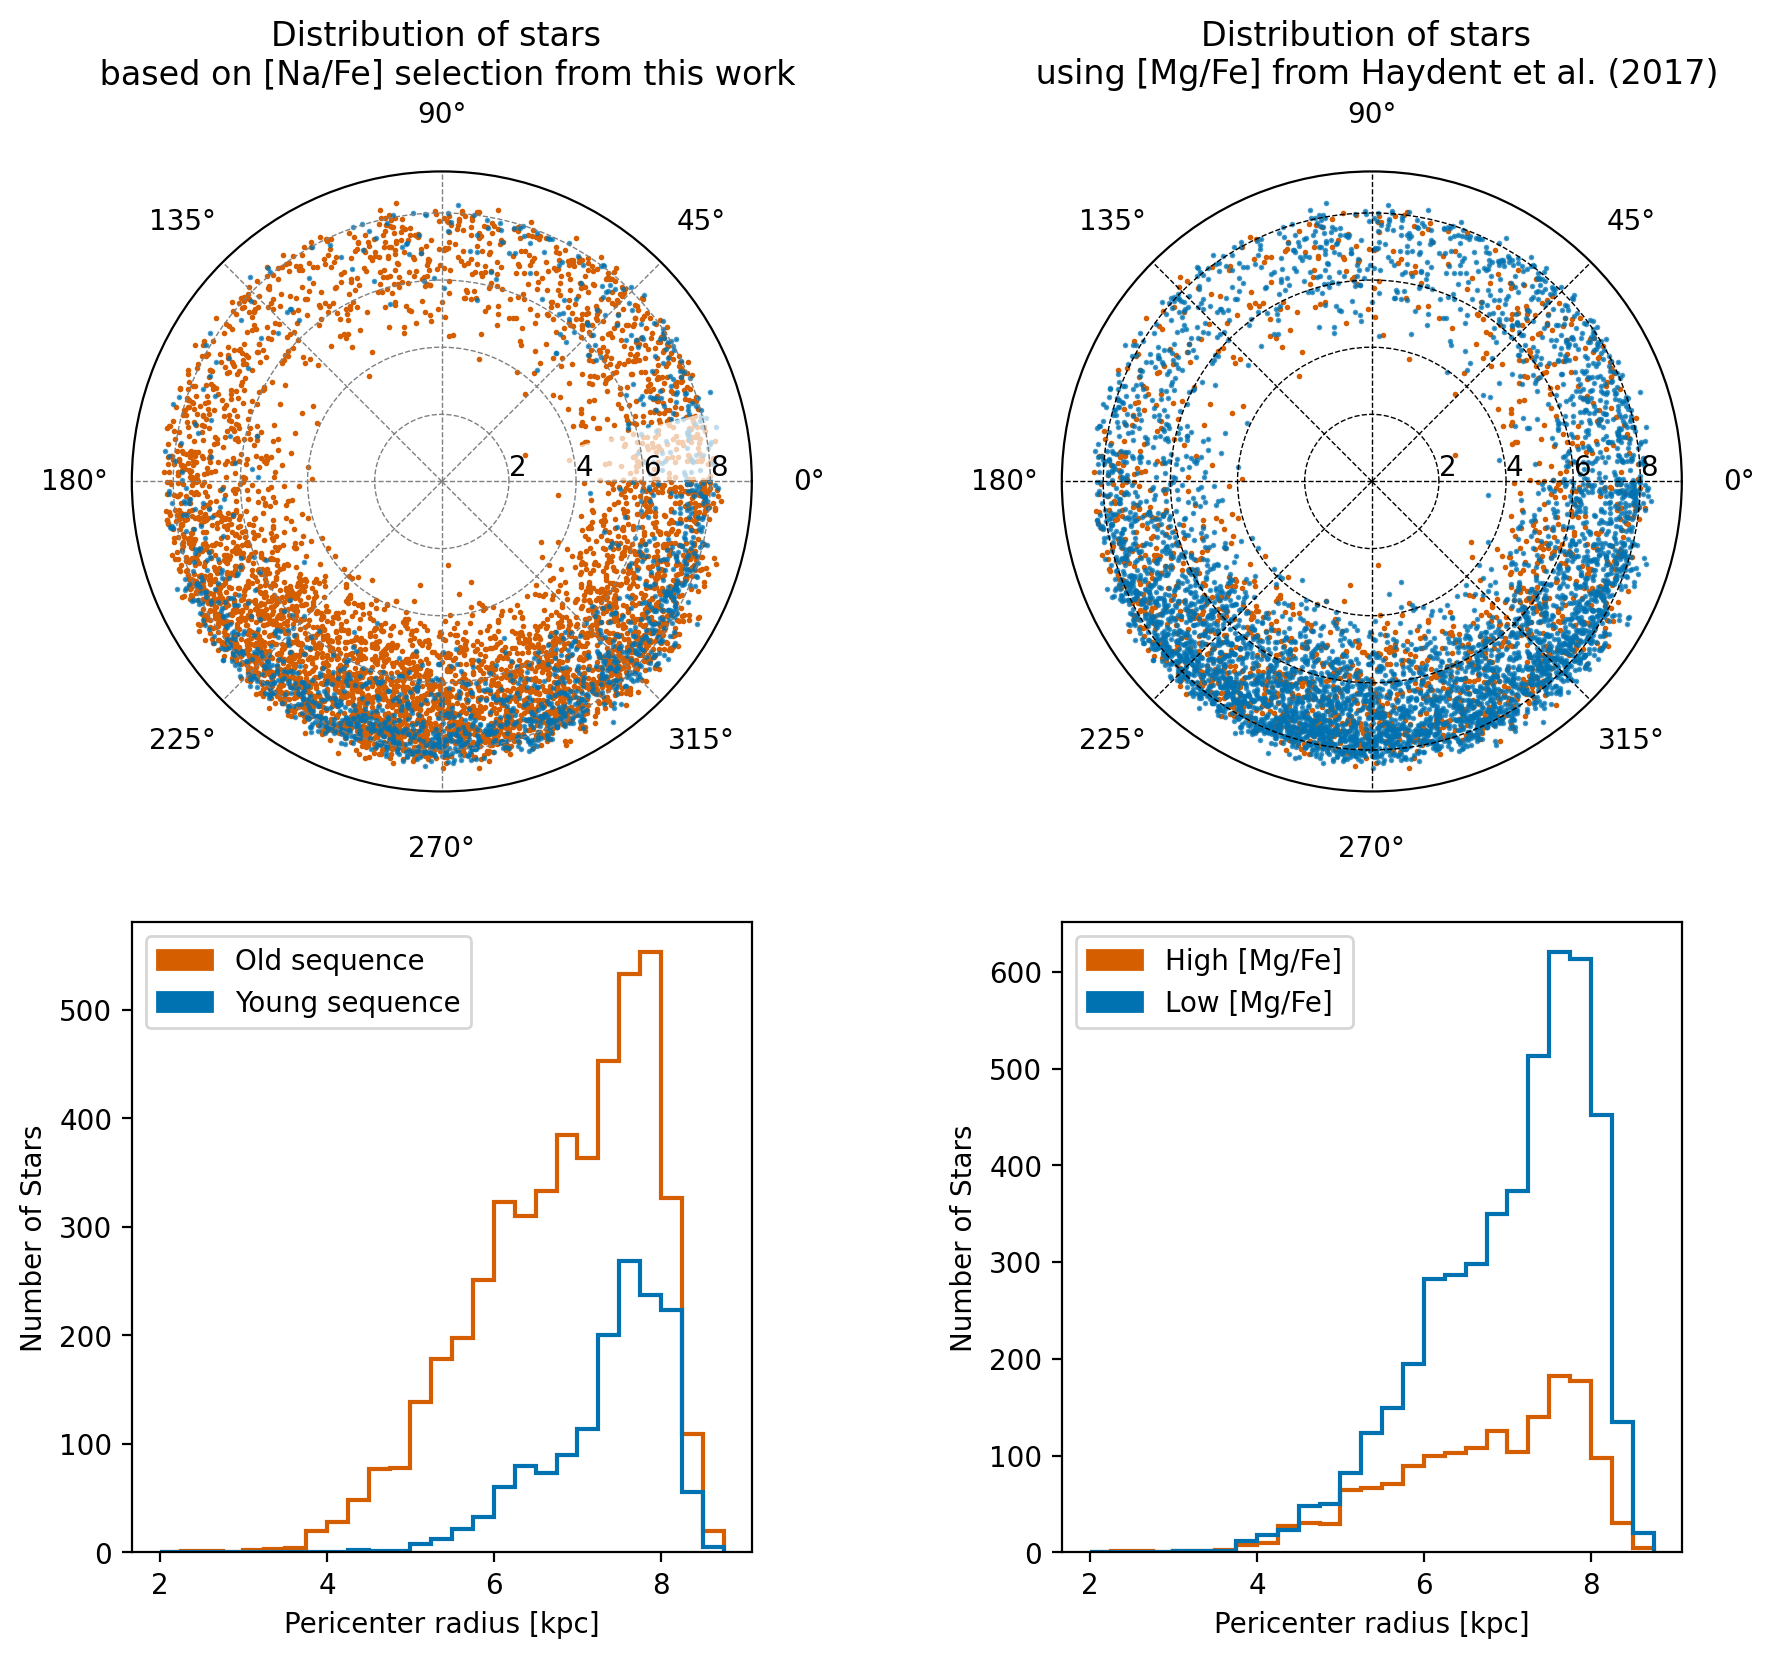

In [11]:

fig, axs = plt.subplots(2, 2, figsize=(10, 9))
# First subplot: Polar plot
ax1 = plt.subplot(2, 2, 1, projection='polar')
ax1.scatter(theta_o, r_o, s=1, color='#D55E00', label='Old Sequence', zorder = -1)
ax1.scatter(theta_y, r_y, s=1, color='#0072B2', alpha=0.7, label='Young Sequence', zorder = -1)
ax1.set_rmax(9)
ax1.set_rticks([2, 4, 6, 8])
ax1.set_rlabel_position(0)
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax1.tick_params(axis='x', size=10)
ax1.tick_params(axis='y', size=10)
ax1.title.set_text('Distribution of stars \n based on [Na/Fe] selection from this work')
ax1.bar(x=0.13, height=8.5,width=0.25, alpha = 0.7, color='white', zorder=0)

# Second subplot: Histogram. 
ax2 = plt.subplot(2, 2, 2, projection='polar')
ax2.scatter(theta_o_hyd, r_o_hyd, s=1, color='#D55E00', label='High [Mg/Fe]')
ax2.scatter(theta_y_hyd, r_y_hyd, s=1, color='#0072B2', alpha=0.7, label='Low [Mg/Fe]')
ax2.set_rmax(9)
ax2.set_rticks([2, 4, 6, 8])    
ax2.set_rlabel_position(0)
ax2.grid(True, linestyle='--', linewidth=0.5, color='black')
ax2.tick_params(axis='x', size=10)
ax2.tick_params(axis='y', size=10)
ax2.bar(x=0.13, height=8.5,width=0.25, alpha = 0.7, color='white', zorder=0)
ax2.title.set_text('Distribution of stars \n using [Mg/Fe] from Haydent et al. (2017)')
# Add legend for the polar plots
old_sequence_patch = mpatches.Patch(color='#D55E00', label='Old sequence')
young_sequence_patch = mpatches.Patch(color='#0072B2', label='Young sequence')
old_sequence_patch_hyd = mpatches.Patch(color='#D55E00', label='High [Mg/Fe]')
young_sequence_patch_hyd = mpatches.Patch(color='#0072B2', label='Low [Mg/Fe]')


# Third subplot: Polar plot
ax3 = plt.subplot(2, 2, 3)
bins = np.arange(2, 9, 0.25)
ax3.hist(r_o, bins=bins, label='Old sequence', color='#D55E00', histtype='step', linewidth=1.5)
ax3.hist(r_y, bins=bins, label='Young sequence', color='#0072B2', histtype='step', linewidth=1.5)
ax3.set_xlabel('Pericenter radius [kpc]')
ax3.set_ylabel('Number of Stars')
ax3.legend(handles=[old_sequence_patch, young_sequence_patch], loc='upper left')
#ax2.set_title('Distribution of Stars Based on [Na/Fe] Classification', fontsize=12)

# Add legend for the two sequences
old_sequence_patch_hyd = mpatches.Patch(color='#D55E00', label='High [Mg/Fe]')
young_sequence_patch_hyd = mpatches.Patch(color='#0072B2', label='Low [Mg/Fe]')
#increse the horizontal distance between [0,1] and [1,1]
plt.subplots_adjust(wspace=0.5)


# Fourth subplot: Histogram
ax4 = plt.subplot(2, 2, 4)
bins = np.arange(2, 9, 0.25)
ax4.hist(r_o_hyd, bins=bins, label='High [Mg/Fe]', color='#D55E00', histtype='step', linewidth=1.5)
ax4.hist(r_y_hyd, bins=bins, label='Low [Mg/Fe]', color='#0072B2', histtype='step', linewidth=1.5)
ax4.set_xlabel('Pericenter radius [kpc]')
ax4.set_ylabel('Number of Stars')
ax4.legend(handles=[old_sequence_patch_hyd, young_sequence_patch_hyd], loc='upper left')
#ax4.set_title('Distribution of Stars Based on [Mg/Fe] Classification', fontsize=12) 
plt.savefig(latexpath + 'figures/old_pericenter_radius.pdf', dpi=200)
plt.show()

In [12]:
######################### Define the orbital peri-galactocentric radius and azimuthal angle for the high and low Na/Fe sequences
r_o_peri = galah['R_peri'][old_sequence]
r_o_apos = galah['R_ap'][old_sequence] 

r_y_peri = galah['R_peri'][young_sequence]
r_y_apos = galah['R_ap'][young_sequence] 

#####################################
r_o_hyd_peri = galah['R_peri'][finite_high_mg]
r_o_hyd_apos = galah['R_ap'][finite_high_mg] 

r_y_hyd_peri = galah['R_peri'][finite_low_mg]
r_y_hyd_apos = galah['R_ap'][finite_low_mg] 

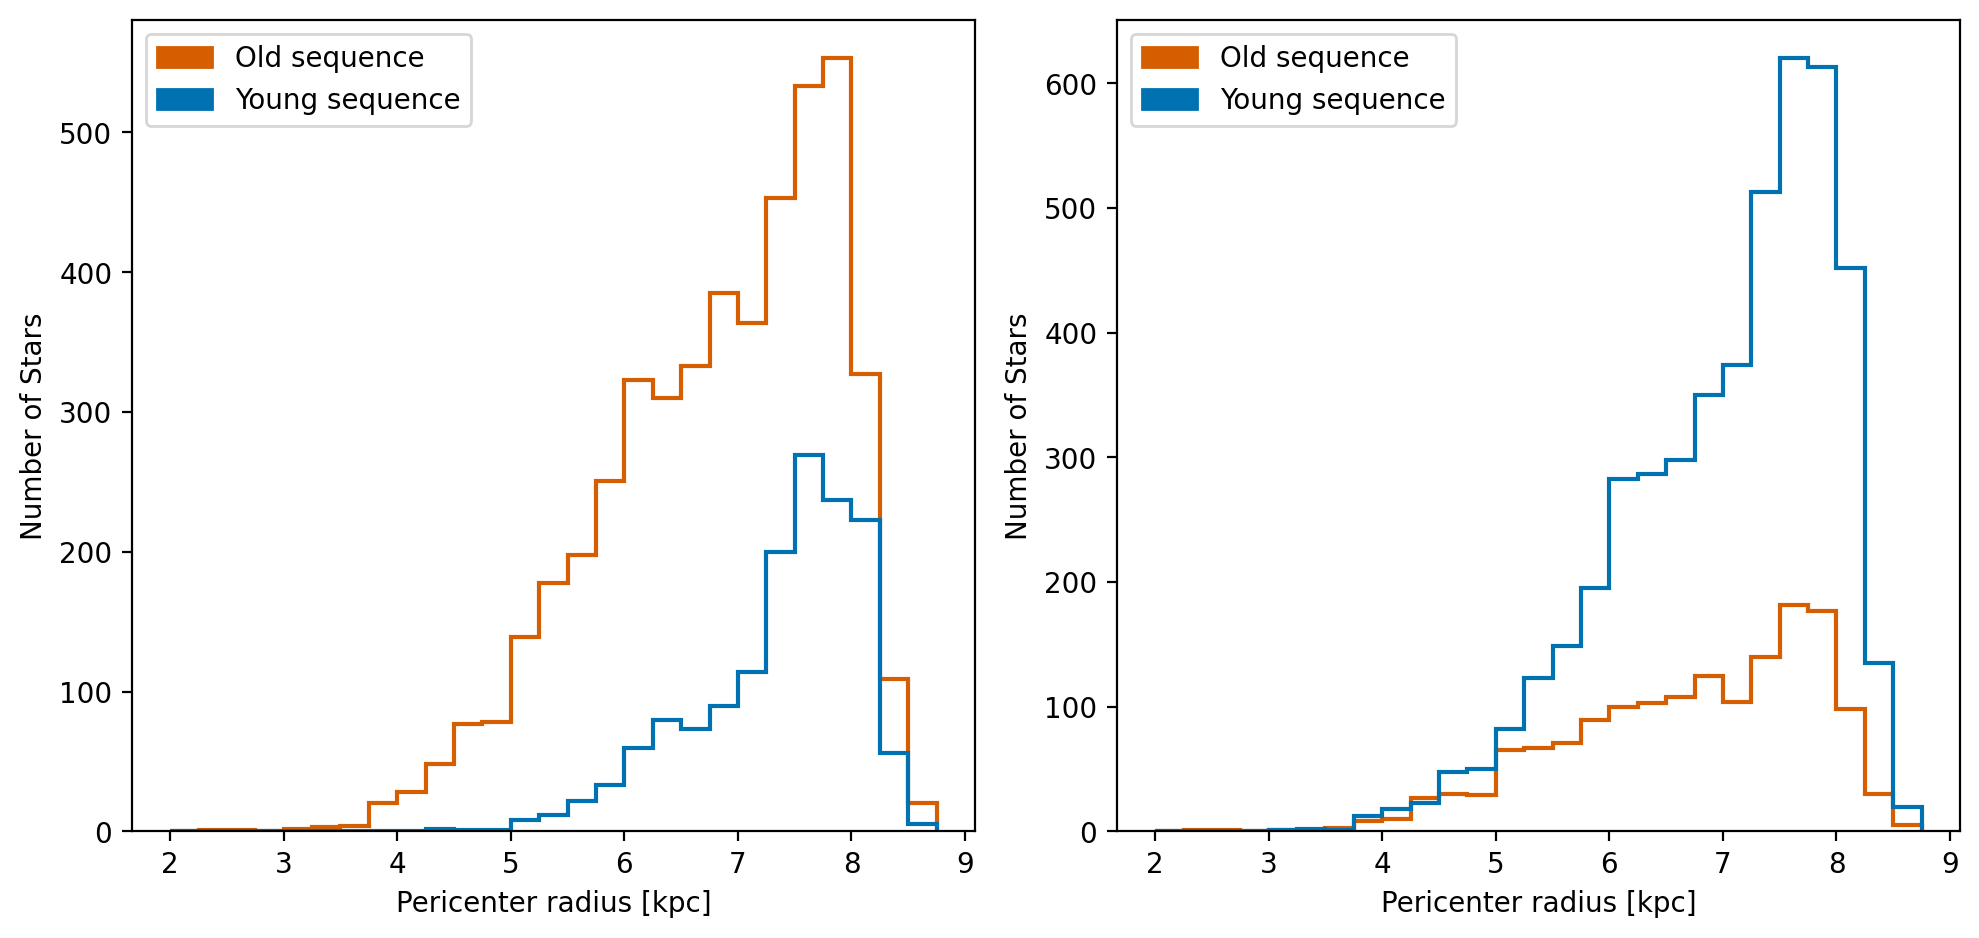

In [13]:
# Add legend for the two sequences
old_sequence_patch_hyd = mpatches.Patch(color='#D55E00', label='Old sequence')
young_sequence_patch_hyd = mpatches.Patch(color='#0072B2', label='Young sequence')
fig, axs = plt.subplots(1,2, figsize=(10, 9))
# First subplot: Polar plot
ax1 =plt.subplot(2,2,1)
bins = np.arange(2, 9, 0.25)
ax1.hist(r_o_peri, bins=bins, label='Old sequence', color='#D55E00', histtype='step', linewidth=1.5)
ax1.hist(r_y_peri, bins=bins, label='Young sequence', color='#0072B2', histtype='step', linewidth=1.5)
ax1.set_xlabel('Pericenter radius [kpc]')
ax1.set_ylabel('Number of Stars')
ax1.legend(handles=[old_sequence_patch, young_sequence_patch], loc='upper left')

#Second subplot: Histogram
ax2 = plt.subplot(2, 2,2)
bins = np.arange(2, 9, 0.25)
ax2.hist(r_o_hyd_peri, bins=bins, label='High [Mg/Fe]', color='#D55E00', histtype='step', linewidth=1.5)
ax2.hist(r_y_hyd_peri, bins=bins, label='Low [Mg/Fe]', color='#0072B2', histtype='step', linewidth=1.5)
ax2.legend(handles=[old_sequence_patch_hyd, young_sequence_patch_hyd], loc=0)
ax2.set_xlabel('Pericenter radius [kpc]')
ax2.set_ylabel('Number of Stars')

# Third subplot: Polar plot
# ax3 = plt.subplot(2, 2, 3)
# bins = np.arange(7, 15, 0.25)
# ax3.hist(r_o_apos, bins=bins,label='Old sequence', color='#D55E00', histtype='step', linewidth=1.5)
# ax3.hist(r_y_apos, bins=bins,label='Young sequence', color='#0072B2', histtype='step', linewidth=1.5)
# ax3.set_xlabel('Apocenter radius [kpc]')
# ax3.set_ylabel('Number of Stars')
# #ax3.set_xlim(6, 9)
# #ax3.legend(handles=[old_sequence_patch, young_sequence_patch], loc=0)
# #ax2.set_title('Distribution of Stars Based on [Na/Fe] Classification', fontsize=12)


# #increse the horizontal distance between [0,1] and [1,1]
# plt.subplots_adjust(wspace=0.5)
# # Fourth subplot: Histogram
# ax4 = plt.subplot(2, 2, 4)
# bins = np.arange(7, 15, 0.25)
# ax4.hist(r_o_hyd_apos, bins=bins, label='High [Mg/Fe]', color='#D55E00', histtype='step', linewidth=1.5)
# ax4.hist(r_y_hyd_apos, bins=bins,label='Low [Mg/Fe]', color='#0072B2', histtype='step', linewidth=1.5)
# ax4.set_xlabel('Apocenter radius [kpc]')
# ax4.set_ylabel('Number of Stars')
#ax4.legend(handles=[old_sequence_patch_hyd, young_sequence_patch_hyd], loc=0)
plt.tight_layout()
plt.savefig(latexpath + 'figures/pericenter_radius.pdf', dpi=200)
plt.show()

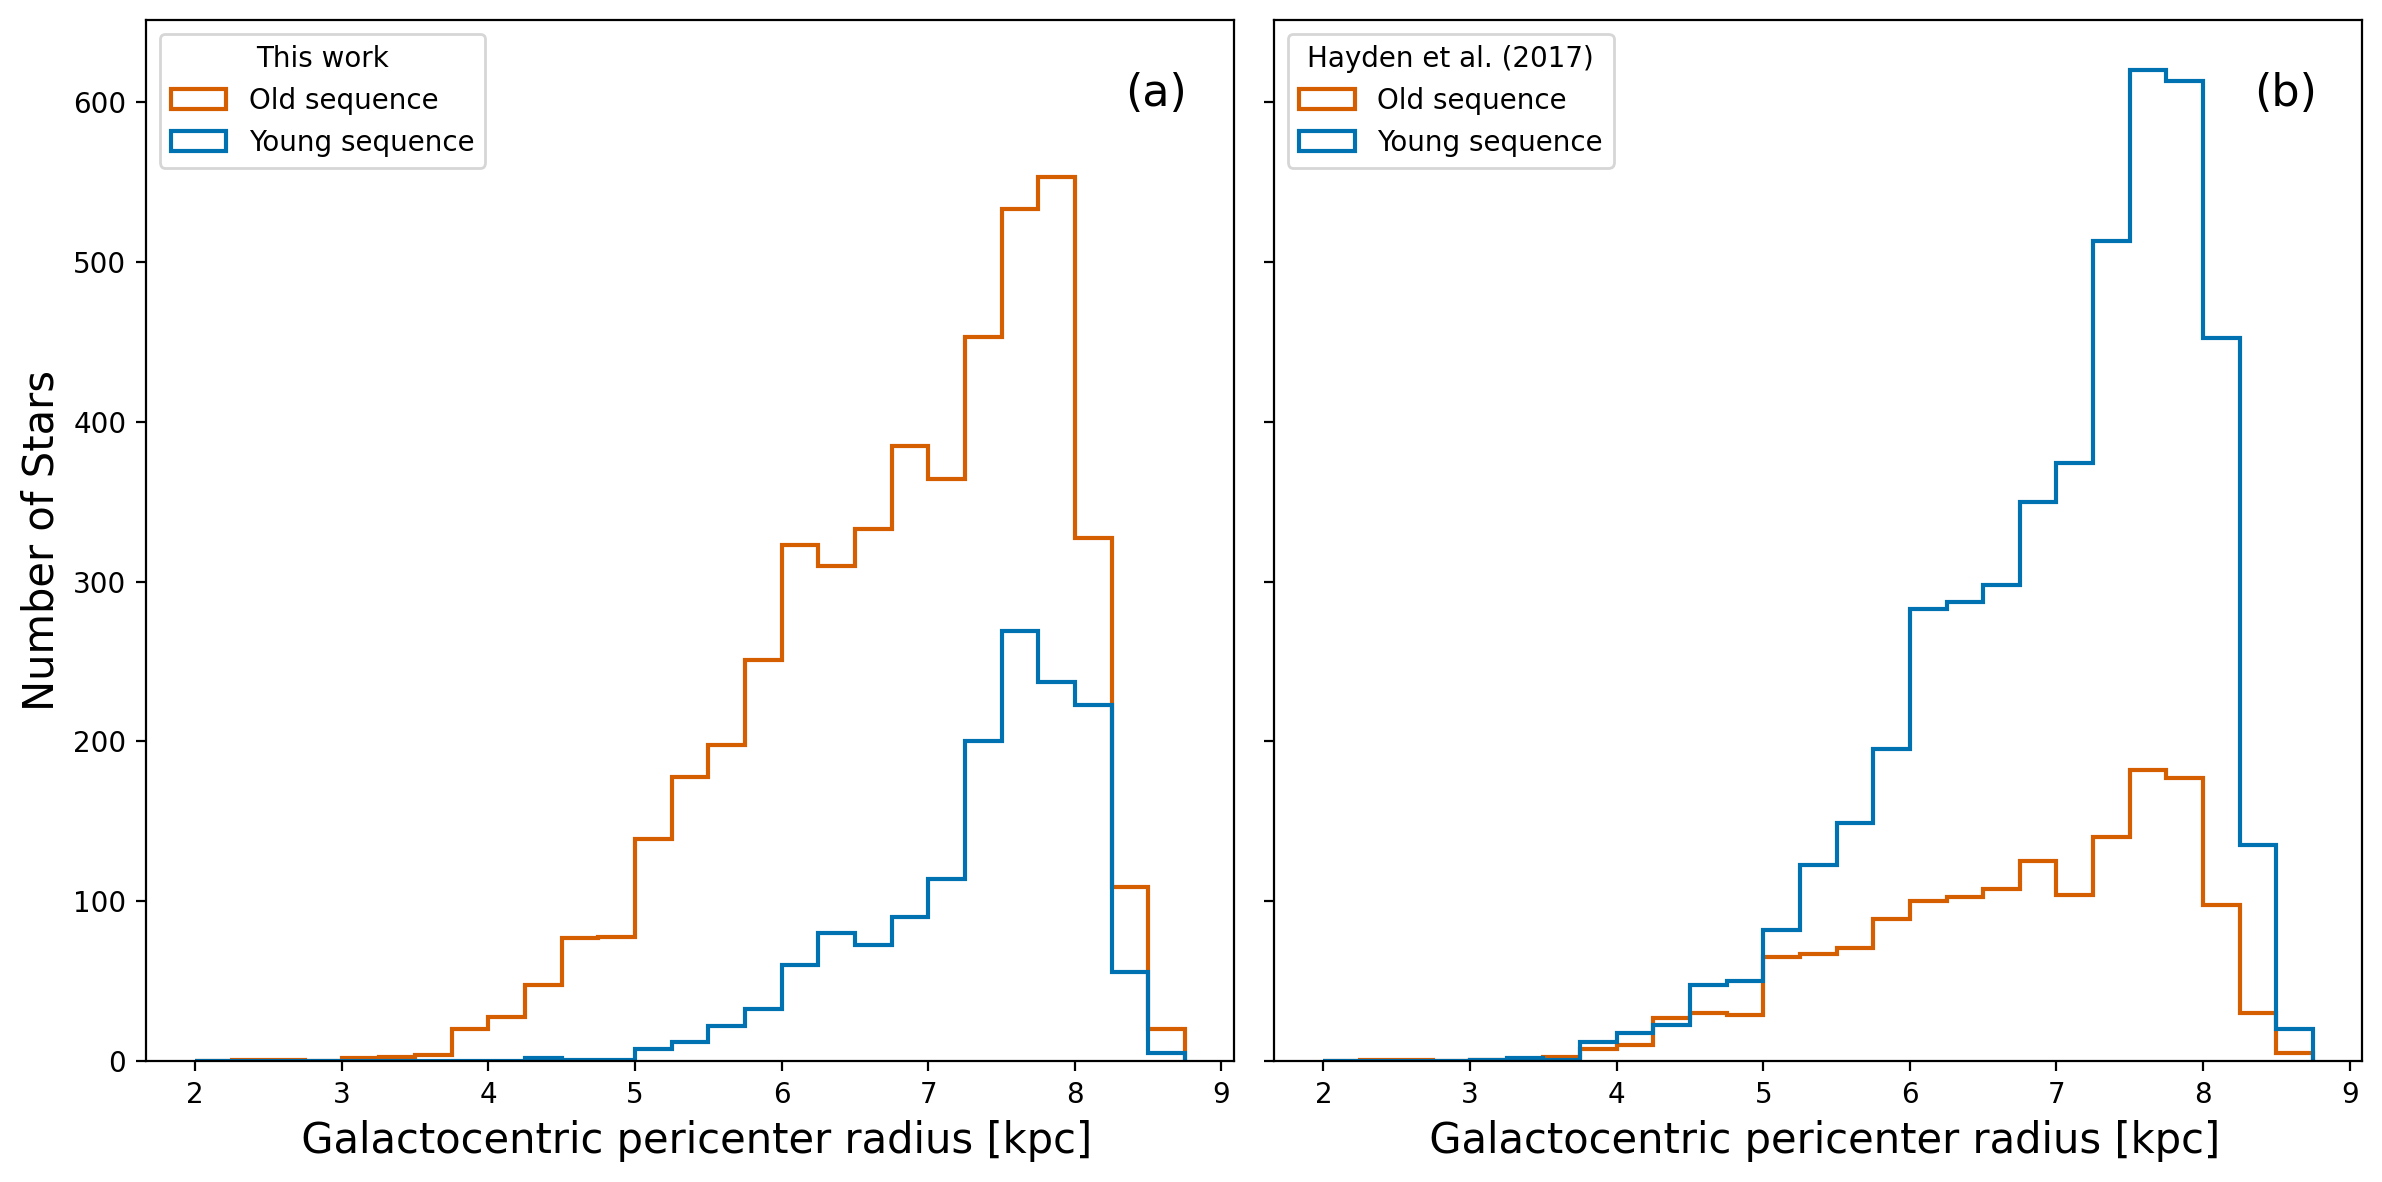

In [35]:
# Define the legend patches
old_sequence_patch_hyd = mpatches.Patch(color='#D55E00', label='Old sequence')
young_sequence_patch_hyd = mpatches.Patch(color='#0072B2', label='Young sequence')

# Create a figure with 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First subplot: Histogram for old and young sequences
bins = np.arange(2, 9, 0.25)
axs[0].hist(r_o_peri, bins=bins, label='Old sequence', color='#D55E00', histtype='step', linewidth=1.5)
axs[0].hist(r_y_peri, bins=bins, label='Young sequence', color='#0072B2', histtype='step', linewidth=1.5)
axs[0].set_xlabel(' Galactocentric pericenter radius [kpc]',fontsize=15)
axs[0].set_ylabel('Number of Stars',fontsize=15)
axs[0].legend(loc='upper left',title='This work')

# Second subplot: Histogram for high and low [Mg/Fe] sequences
axs[1].hist(r_o_hyd_peri, bins=bins, label='Old sequence', color='#D55E00', histtype='step', linewidth=1.5)
axs[1].hist(r_y_hyd_peri, bins=bins, label='Young sequence', color='#0072B2', histtype='step', linewidth=1.5)
axs[1].set_xlabel(' Galactocentric pericenter radius [kpc]', fontsize=15)
old_sequence_patch = mpatches.Patch(color='#D55E00', label='Old sequence')
axs[1].legend(loc='upper left',title='Hayden et al. (2017)')

#add panel labels a and b
axs[0].text(0.9, 0.95, '(a)', transform=axs[0].transAxes, fontsize=16, verticalalignment='top')
axs[1].text(0.9, 0.95, '(b)', transform=axs[1].transAxes, fontsize=16, verticalalignment='top')

#legend(handles=[old_sequence_patch_hyd, young_sequence_patch_hyd], loc='upper left')

plt.tight_layout()
plt.savefig(latexpath + 'figures/pericenter_radius.pdf', dpi=200)
plt.show()

In [15]:
# sodium_old = galah['Na_fe'][old_sequence]
# sodium_young = galah['Na_fe'][young_sequence]
# #make a histogram of the azimuthal angle for the old and young sequences
# fig, ax = plt.subplots()
# ax.hist(sodium_old, alpha=0.5, label='[Na/Fe]_old-sequence', bins = 15)
# ax.hist(sodium_young, alpha=0.5, label='[Na/Fe]_young-sequence', bins =15)
# # ax.set_xlabel('Galactocentric azimuthal angle [degrees]')
# # ax.set_ylabel('Number of stars')
# plt.legend()

In [16]:
# above_hayden_line = (
#     solar_type & 
#     (
#         # [Fe/H] < -0.4
#         (
#             (galah['fe_h'] <= -0.4) & 
#             (galah['Mg_fe'] >= 0.22)
#         ) |
#         # [Fe/H] >= 0.0
#         (
#             (galah['fe_h'] >= 0.0) & 
#             (galah['Mg_fe'] >= 0.0)
#         ) |
#         # in-between
#         (
#             (galah['fe_h'] > -0.4) & 
#             (galah['fe_h'] < 0.0) & 
#             (galah['Mg_fe'] >= -0.22 * galah['fe_h']/0.4)
#         )
#     )
# )

# above_hayden_old = (
#     above_hayden_line & 
#     old_sequence
# )
# above_hayden_young = (
#     above_hayden_line & 
#     young_sequence
# )

# below_hayden_line = (
#     solar_type & 
#     ~(
#         # [Fe/H] < -0.4
#         (
#             (galah['fe_h'] <= -0.4) & 
#             (galah['Mg_fe'] >= 0.22)
#         ) |
#         # [Fe/H] >= 0.0
#         (
#             (galah['fe_h'] >= 0.0) & 
#             (galah['Mg_fe'] >= 0.0)
#         ) |
#         # in-between
#         (
#             (galah['fe_h'] > -0.4) & 
#             (galah['fe_h'] < 0.0) & 
#             (galah['Mg_fe'] >= -0.22 * galah['fe_h']/0.4)
#         )
#     )
# )

In [17]:
above_hayden_line = (
    solar_type & 
    (
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

above_hayden_old = (
    above_hayden_line & 
    old_sequence
)
above_hayden_young = (
    above_hayden_line & 
    young_sequence
)

below_hayden_line = (
    solar_type & 
    ~(
        # [Fe/H] < -0.4
        (
            (galah['fe_h'] <= -0.475) & 
            (galah['Mg_fe'] >= 0.22)
        ) |
        # [Fe/H] >= 0.102
        (
            (galah['fe_h'] >= 0.1) & 
            (galah['Mg_fe'] >= 0.0)
        ) |
        # in-between
        (
            (galah['fe_h'] > -0.475) & 
            (galah['fe_h'] < 0.1) & 
            (galah['Mg_fe'] >= -0.383 * galah['fe_h']+0.0383)
        )
    )
)

# below_hayden_old = (
#     below_hayden_line & 
#     old_sequence&np.logical_not(np.isnan(galah['fe_h']))
# )

# below_hayden_young = (
#     below_hayden_line & 
#     young_sequence &np.logical_not(np.isnan(galah['fe_h']))
# )

# print('above_hayden_old', len(galah['fe_h'][above_hayden_old]), np.round(100 * len(galah['fe_h'][above_hayden_old])/len(galah['fe_h'][solar_type]),2))
# print('above_hayden_young',len(galah['fe_h'][above_hayden_young]), np.round(100 * len(galah['fe_h'][above_hayden_young])/len(galah['fe_h'][solar_type]),2))
# print('below_hayden_old',len(galah['fe_h'][below_hayden_old]), np.round(100 * len(galah['fe_h'][below_hayden_old])/len(galah['fe_h'][solar_type]),2))
# print('below_hayden_young',len(galah['fe_h'][below_hayden_young]), np.round(100 * len(galah['fe_h'][below_hayden_young])/len(galah['fe_h'][solar_type]),2))

# f, gs = plt.subplots(1,2)

# ax = gs[0]
# ax.scatter(
#     galah['fe_h'][solar_type & ~above_hayden_line],
#     galah['Mg_fe'][solar_type & ~above_hayden_line],
#     s = 1
# )
# ax.scatter(
#     galah['fe_h'][solar_type & above_hayden_line],
#     galah['Mg_fe'][solar_type & above_hayden_line],
#     s = 1
# )

# ax = gs[1]
# ax.scatter(
#     galah['age_bstep'][solar_type & ~above_hayden_line],
#     galah['Na_fe'][solar_type & ~above_hayden_line],
#     s = 1
# )
# ax.scatter(
#     galah['age_bstep'][solar_type & above_hayden_line],
#     galah['Na_fe'][solar_type & above_hayden_line],
#     s = 1
# )


In [18]:
#finite data for high Na/Fe (thick disc - old sequence) and low Na/Fe (thin disc - young sequence)
# finite_high_mg = np.logical_and(above_hayden_line, np.logical_not(np.isnan(galah['fe_h'])))
# finite_low_mg = np.logical_and(below_hayden_line, np.logical_not(np.isnan(galah['fe_h'])))

# Function to compute velocity dispersion and SEM
def compute_velocity_dispersion_age_hyd(array, bins):
    velocities_hyd = array['vz_Rzphi']
    ages_hyd = array['age_bstep']
    dispersions_hyd = []
    sems_hyd = []  # List to store the standard error of the mean
    mean_ages_hyd = []

    for i in range(len(bins) - 1):
        mask = np.logical_and(ages_hyd >= bins[i], ages_hyd < bins[i + 1])
        total_hyd = sum(mask)
        if total_hyd >=10:
            dispersion_hyd = np.std(velocities_hyd[mask])
            dispersions_hyd.append(dispersion_hyd)
            sem_hyd = dispersion_hyd / np.sqrt(total_hyd)  # Standard error of the mean
            sems_hyd.append(sem_hyd)
        else:
            dispersions_hyd.append(np.nan)
            sems_hyd.append(np.nan)
        mean_ages_hyd.append((bins[i] + bins[i + 1]) / 2)
    return mean_ages_hyd, dispersions_hyd, sems_hyd

# Filter the data based on non-NaN values for the relevant parameters
galah_not_nan_hyd = galah[np.logical_or(finite_high_mg, finite_low_mg)]
age_bins_hyd = np.arange(2, 13, 1.5).astype(int)

# Compute velocity dispersion and SEM for all three groups
all_ages_hyd, all_dispersion_hyd, all_sems_hyd = compute_velocity_dispersion_age_hyd(galah_not_nan_hyd, age_bins_hyd)
high_na_ages_hyd, high_na_dispersion_hyd, high_na_sems_hyd = compute_velocity_dispersion_age_hyd(galah[finite_high_mg], age_bins_hyd)
low_na_ages_hyd, low_na_dispersion_hyd, low_na_sems_hyd = compute_velocity_dispersion_age_hyd(galah[finite_low_mg], age_bins)

# Plot the velocity dispersions with error bars
# plt.figure(figsize=(7, 6))
# plt.errorbar(high_na_ages_hyd, high_na_dispersion_hyd, yerr=high_na_sems_hyd, marker='s', linestyle='-', color='royalblue', label='Old Sequence', capsize=3)
# plt.errorbar(low_na_ages_hyd, low_na_dispersion_hyd, yerr=low_na_sems_hyd, marker='^', linestyle='--', color='g', label='Young Sequence', capsize=3)
# plt.errorbar(all_ages_hyd, all_dispersion_hyd, yerr=all_sems_hyd, marker='o', linestyle='-.', color='#3c3c3c', label='Solar Type Stars', capsize=3)

# plt.xlabel('Age [Gyr]')
# plt.ylabel('$\mathrm{\sigma}_z$[km/s]')
# plt.xlim(0, 12)
# plt.title('Velocity Dispersion vs Age using our [Mg/Fe] cut')
# plt.legend()
# plt.tight_layout()
# plt.savefig(latexpath + 'velocity_dispersion_age_hyden.png', dpi=300)
# plt.show()


In [19]:
print('above_hayden', len(galah[finite_high_mg]["fe_h"]))#, np.round(100 * len(galah['fe_h'][finite_high_mg])/len(galah_not_nan_hyd),2))
print('below_hayden',len(galah[finite_low_mg]["fe_h"]))#, np.round(100 * len(galah['fe_h'][finite_low_mg])/len(galah_not_nan_hyd),2))

print('above_owusu', len(galah[finite_high_na]["fe_h"]))#, np.round(100 * len(galah['fe_h'][finite_high_na])/len(galah_not_nan),2))
print('below_owusu',len(galah[finite_low_na]["fe_h"]))#, np.round(100 * len(galah['fe_h'][finite_low_na])/len(galah_not_nan),2))

above_hayden 1576
below_hayden 4658
above_owusu 4743
below_owusu 1491


In [20]:
print(sum(np.ma.getmaskarray(finite_high_mg)))
print(finite_high_mg[1].data)

85750
0.0


#### Figure for velocity dispersion

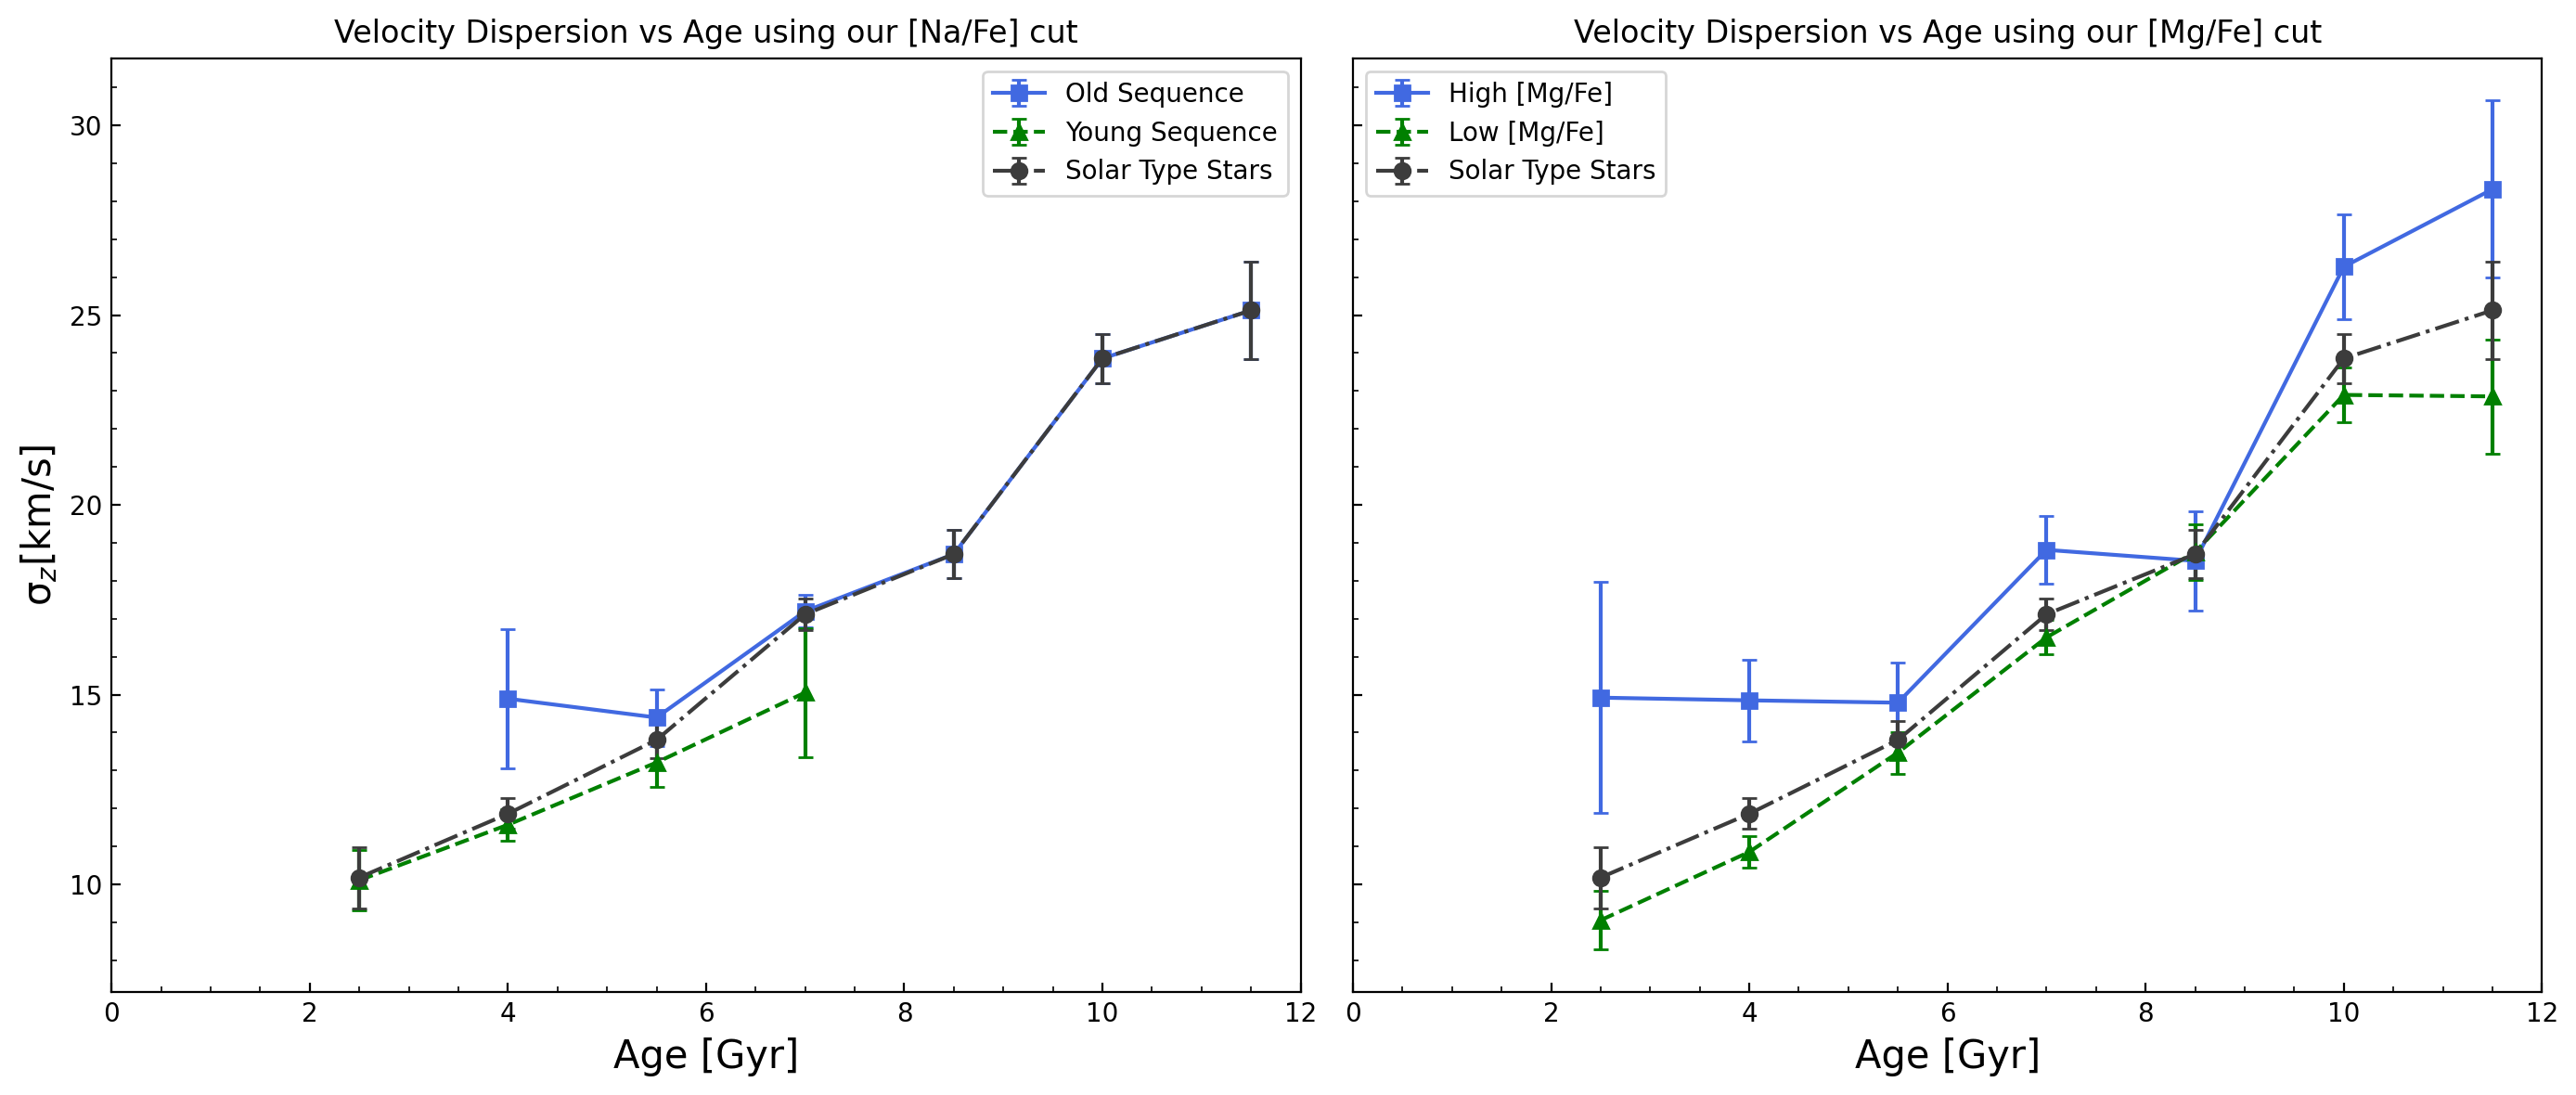

In [21]:
# Define figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True) 
#make horizongtal distance between the two subplots 
plt.subplots_adjust(hspace=0, wspace=0.1)

# First subplot
axs[0].errorbar(high_na_ages, high_na_dispersion, yerr=high_na_sems, marker='s', linestyle='-', color='royalblue', label='Old Sequence', capsize=3)
axs[0].errorbar(low_na_ages, low_na_dispersion, yerr=low_na_sems, marker='^', linestyle='--', color='g', label='Young Sequence', capsize=3)
axs[0].errorbar(all_ages, all_dispersion, yerr=all_sems, marker='o', linestyle='-.', color='#3c3c3c', label='Solar Type Stars', capsize=3)
axs[0].set_xlabel('Age [Gyr]', fontsize=15)
axs[0].set_ylabel('$\mathrm{\sigma}_z$[km/s]', fontsize=15)
axs[0].set_title('Velocity Dispersion vs Age using our [Na/Fe] cut')
axs[0].legend(loc=0)
axs[0].set_xlim(0, 12)

# Second subplot
axs[1].errorbar(high_na_ages_hyd, high_na_dispersion_hyd, yerr=high_na_sems_hyd, marker='s', linestyle='-', color='royalblue', label='High [Mg/Fe]', capsize=3)
axs[1].errorbar(low_na_ages_hyd, low_na_dispersion_hyd, yerr=low_na_sems_hyd, marker='^', linestyle='--', color='g', label='Low [Mg/Fe]', capsize=3)
axs[1].errorbar(all_ages_hyd, all_dispersion_hyd, yerr=all_sems_hyd, marker='o', linestyle='-.', color='#3c3c3c', label='Solar Type Stars', capsize=3)
axs[1].set_xlabel('Age [Gyr]', fontsize=15)
axs[1].set_title('Velocity Dispersion vs Age using our [Mg/Fe] cut')
axs[1].legend(loc=0)
axs[1].set_xlim(0, 12)
#add major and minor ticks inside both subplots and direct the ticks inward
axs[0].xaxis.set_tick_params(direction='in', which='both')
axs[0].yaxis.set_tick_params(direction='in', which='both')
axs[1].xaxis.set_tick_params(direction='in', which='both')
axs[1].yaxis.set_tick_params(direction='in', which='both')
#minor ticks for both subplots inside the subplots
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
plt.tight_layout()
# Save and display the plot
plt.savefig(latexpath + 'figures/velocity_dispersion_age_subplot.pdf', dpi=300)
plt.show()


### Kinematical selection criteria based on Bensby et al. (2014)


- The kinematical criteria that we have used as a starting point to select candidate thin and thick disk stars assumes that the Galactic space velocities ($U_{\text{LSR}}$, $V_{\text{LSR}}$, and $W_{\text{LSR}}$) of the stellar populations have Gaussian distributions,
The kinematical criteria that we have used as a starting point to select candidate thin and thick disk stars assumes that the Galactic space velocities ($U_{\text{LSR}}$, $V_{\text{LSR}}$, and $W_{\text{LSR}}$) of the stellar populations have Gaussian distributions,

$$
P(U_{\text{LSR}}, V_{\text{LSR}}, W_{\text{LSR}}) = \frac{1}{(2\pi)^{3/2} \sigma_U \sigma_V \sigma_W} \exp\left(-\frac{1}{2} \left( \frac{(U_{\text{LSR}}-U_{\text{sym}})^2}{\sigma_U^2} + \frac{(V_{\text{LSR}}V_{\text{sym}})^2}{\sigma_V^2} + \frac{(W_{\text{LSR}}-W_{\text{sym}})^2}{\sigma_W^2} \right) \right),
\tag{A.1}
$$

- where

$$
\sigma_U, \sigma_V, \sigma_W \text{ are the velocity dispersions in the } U_{\text{LSR}}, V_{\text{LSR}}, \text{ and } W_{\text{LSR}} \text{ directions respectively.}
$$




- To get the probability (which we will call $D$, $TD$, and $H$, for the thin disk, thick disk, and stellar halo, respectively) that a given star belongs to a specific population, the probabilities from Eq. (A.1) should be multiplied by the observed fractions ($X$) of each population in the Solar neighbourhood. By then dividing the thick disk probability ($TD$) with the thin disk ($D$) and halo ($H$) probabilities, respectively, we get two relative probabilities for the thick disk-to-thin disk ($TD/D$) and thick disk-to-halo ($TD/H$) membership, i.e.

$$
\text{TD/D} = \frac{X_{TD}}{X_D}.\frac{f_{TD}}{f_D}
\tag{A.2}
$$

- and likewise for other probability ratios.


In [22]:
#define old and young sequence data for the UVW velocities
# ulsr_old = galah['U_UVW_50'][old_sequence]
# vlsr_old = galah['V_UVW_50'][old_sequence]
# wlsr_old = galah['W_UVW_50'][old_sequence]

# ulsr_young = galah['U_UVW_50'][young_sequence]
# vlsr_young = galah['V_UVW_50'][young_sequence]
# wlsr_young = galah['W_UVW_50'][young_sequence]

ulsr = galah['U_UVW']
vlsr = galah['V_UVW']
wlsr = galah['W_UVW']

# U = galah['U_UVW']
# V = galah['V_UVW']
# W = galah['W_UVW']

# ulsr_high_mg = galah['U_UVW_50'][finite_high_mg]
# vlsr_high_mg = galah['V_UVW_50'][finite_high_mg]
# wlsr_high_mg = galah['W_UVW_50'][finite_high_mg]

# ulsr_low_mg = galah['U_UVW_50'][finite_low_mg]
# vlsr_low_mg = galah['V_UVW_50'][finite_low_mg]
# wlsr_low_mg = galah['W_UVW_50'][finite_low_mg]

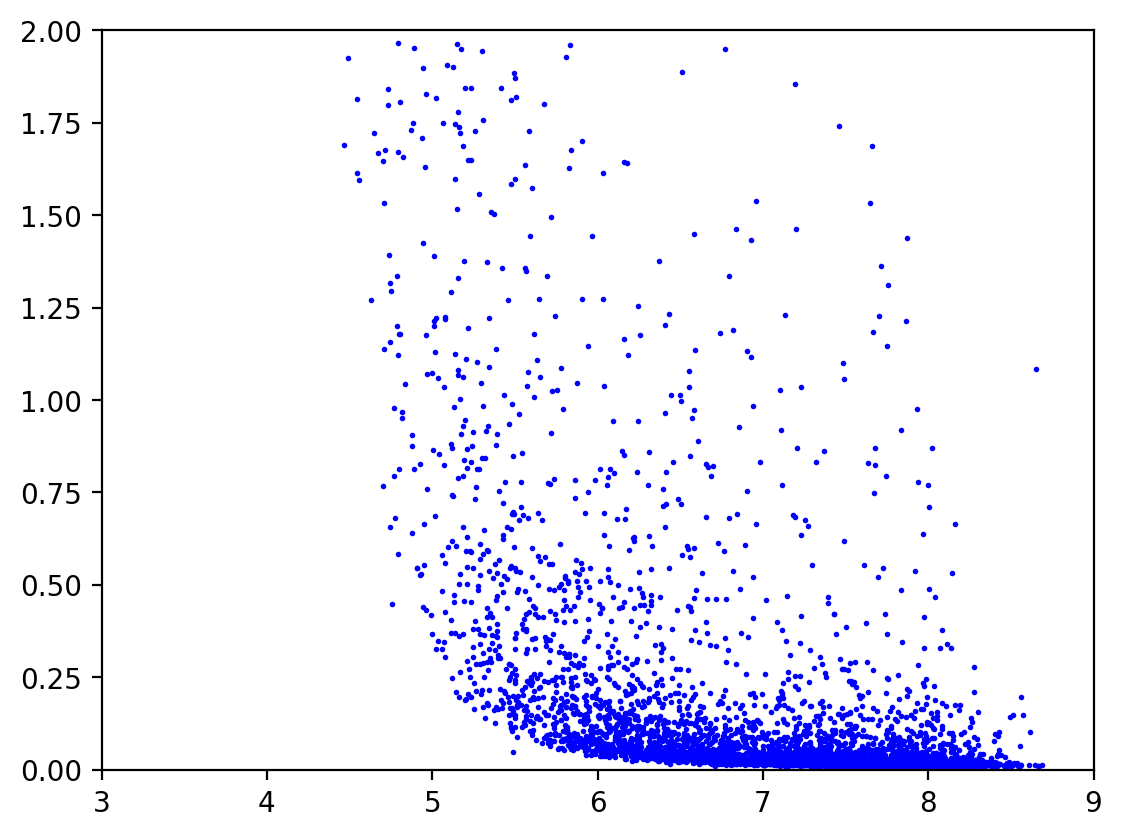

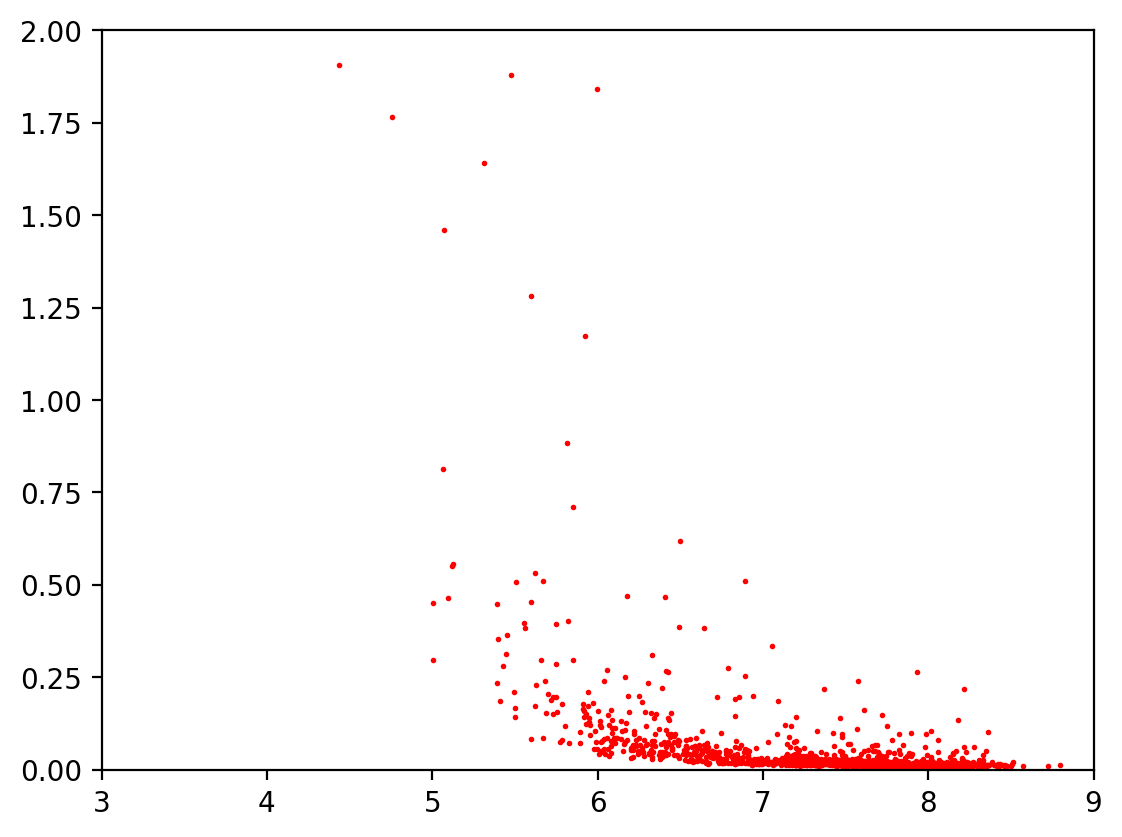

In [23]:
#Define parameters for the UVW velocities
#parameters for the thin disc
sigma_u_D = 35
sigma_v_D = 20
sigma_w_D = 16
U_asym_D = 0.0
V_asym_D = -15
X_D = 0.85 

#parameters for the thick disc
sigma_u_TD = 67
sigma_v_TD = 38
sigma_w_TD = 35
U_asym_TD = 0.0
V_asym_TD = -46
X_TD = 0.09

#Define the equation for the density distribution of the thin and thick disc
#k_D = 1/((2*np.pi)**1.5*sigma_u_D*sigma_v_D*sigma_w_D)

#k_TD = 1/((2*np.pi)**1.5*sigma_u_TD*sigma_v_TD*sigma_w_TD)  

#kinematic parameters for the thin disc
def distribution(U, V, W, U_asym, V_asym, sigma_u, sigma_v, sigma_w):
    k = 1/((2*np.pi)**1.5*sigma_u*sigma_v*sigma_w)
    return k*np.exp(-0.5*((U-U_asym)**2/sigma_u**2 + (V-V_asym)**2/sigma_v**2 
                            + (W)**2/sigma_w**2))
f_D = distribution(ulsr, vlsr, wlsr, U_asym_D, V_asym_D, sigma_u_D, sigma_v_D, sigma_w_D)
f_TD = distribution(ulsr, vlsr, wlsr, U_asym_TD, V_asym_TD, sigma_u_TD, sigma_v_TD, sigma_w_TD)

TD_D = X_TD*f_TD/(X_D*f_D)

thick_thin_old = TD_D[solar_type & high_na]
thick_thin_young = TD_D[solar_type & low_na]

plt.scatter(r_o, thick_thin_old, s=1, color='blue', label='Old sequence')
plt.ylim(0,2)
plt.xlim(3,9)
plt.show()

plt.scatter(r_y, thick_thin_young, s=1, color='red', label='Young sequence')
plt.ylim(0,2)
plt.xlim(3,9)
plt.show()